In [1]:
import torch
from torch import nn
import torchvision as tv

Используя сверточные слои и архитектуру получите на fashion mnist качество не ниже 89,5%


In [2]:
import time
import matplotlib.pyplot as plt

In [3]:
Fmnist_train = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
Fmnist_test  = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)

In [4]:
labels_f={0:	'T-shirt/top',
1:	'Trouser',
2:	'Pullover',
3:	'Dress',
4:	'Coat',
5:	'Sandal',
6:	'Shirt',
7:	'Sneaker',
8:	'Bag',
9	:'Ankle boot'}

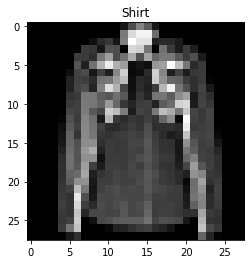

In [5]:
#Fmnist_train[0][0].reshape(28,28)#.shape
i=135
plt.title(labels_f[Fmnist_test[i][1]])
plt.imshow(Fmnist_test[i][0].numpy().reshape((28,28)), cmap='gray')

In [0]:
#Option I: LeNet
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(300, 80),
    nn.ReLU(),
    nn.Linear(80, 10)
)

loss = torch.nn.CrossEntropyLoss(reduction='sum')
#trainer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = torch.optim.Adam(model.parameters())

In [35]:
#Option II: LeNet Another classification head
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 12, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),

    #torch.nn.BatchNorm1d(num_features=300),
    #torch.nn.Dropout(0.3),
    torch.nn.Linear(300, 150),
    torch.nn.ReLU(),

    #torch.nn.BatchNorm1d(num_features=150),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(150, 80),
    torch.nn.ReLU(),

    #torch.nn.BatchNorm1d(num_features=80),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(80, 10)
)

loss = torch.nn.CrossEntropyLoss(reduction='sum')
#trainer = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = torch.optim.Adam(model.parameters())


In [36]:
X = Fmnist_train[0][0]
X = X.reshape(1, 1, 28, 28)
print(X.shape)
for l in model:
    X = l(X)
    print("Layer {}. X shape: {}".format(l, X.shape))

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 6, 28, 28])
Layer ReLU(). X shape: torch.Size([1, 6, 28, 28])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 6, 14, 14])
Layer Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1)). X shape: torch.Size([1, 12, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 12, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 12, 5, 5])
Layer Flatten(). X shape: torch.Size([1, 300])
Layer Linear(in_features=300, out_features=150, bias=True). X shape: torch.Size([1, 150])
Layer ReLU(). X shape: torch.Size([1, 150])
Layer Dropout(p=0.2, inplace=False). X shape: torch.Size([1, 150])
Layer Linear(in_features=150, out_features=80, bias=True). X shape: torch.Size([1, 80])
Layer ReLU(). X shape: torch.Size([1, 80])
Layer Dropout(p=0.2, inplace=False). X shape: torch.Size([

In [37]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [38]:
print(torch.cuda.is_available(), dev)

True cuda


In [39]:
model = model.to(dev)

In [40]:
train, test = torch.utils.data.DataLoader(Fmnist_train, 256, shuffle=True), torch.utils.data.DataLoader(Fmnist_test, 256)

In [42]:
num_epochs = 20
for epoch in range(0, num_epochs):
    start, train_loss, train_acc, train_n, test_loss, test_acc, test_n = time.time(), 0., 0., 0, 0., 0., 0
    
    model.train()
    for X, y in train:
        X=X.to(dev)
        y=y.to(dev)
        trainer.zero_grad()
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
        train_loss += l.item()
        train_acc += (y_hat.argmax(dim=1) == y).sum().item()
        train_n += len(X)
    
    model.eval()
    for X, y in test:
        X=X.to(dev)
        y=y.to(dev)
        y_hat = model.forward(X)
        l = loss(y_hat, y)
        test_loss += l.item()
        test_acc += (y_hat.argmax(dim=1) == y).sum().item()
        test_n += len(X)   
        
    print("""epoch {}, took: {:.3f}
train -> loss: {:.3f}, acc: {:.3f}
test -> loss: {:.3f}, acc: {:.3f}
""".format(epoch, time.time() - start, train_loss / train_n, train_acc / train_n,
       test_loss / test_n, test_acc / test_n))


epoch 0, took: 6.743
train -> loss: 0.402, acc: 0.853
test -> loss: 0.389, acc: 0.859

epoch 1, took: 6.635
train -> loss: 0.379, acc: 0.861
test -> loss: 0.363, acc: 0.870

epoch 2, took: 6.607
train -> loss: 0.358, acc: 0.870
test -> loss: 0.348, acc: 0.874

epoch 3, took: 6.633
train -> loss: 0.344, acc: 0.873
test -> loss: 0.334, acc: 0.881

epoch 4, took: 6.624
train -> loss: 0.332, acc: 0.880
test -> loss: 0.334, acc: 0.876

epoch 5, took: 6.616
train -> loss: 0.321, acc: 0.883
test -> loss: 0.327, acc: 0.880

epoch 6, took: 6.727
train -> loss: 0.311, acc: 0.887
test -> loss: 0.316, acc: 0.886

epoch 7, took: 6.658
train -> loss: 0.303, acc: 0.888
test -> loss: 0.313, acc: 0.887

epoch 8, took: 6.623
train -> loss: 0.295, acc: 0.892
test -> loss: 0.314, acc: 0.884

epoch 9, took: 6.742
train -> loss: 0.288, acc: 0.894
test -> loss: 0.300, acc: 0.891

epoch 10, took: 6.623
train -> loss: 0.280, acc: 0.896
test -> loss: 0.296, acc: 0.893

epoch 11, took: 6.644
train -> loss: 0.273

In [43]:
#y_pred=torch.Tensor([1], dtypes=torch.int64)
y_pred=torch.zeros((1), dtype=torch.int64).to(dev)
y_true=torch.zeros((1), dtype=torch.int64).to(dev)
model.eval()
for X, y in test:
    X=X.to(dev)
    y=y.to(dev)  
    #pass
    #y_hat = model.forward(X)
    y_hat = model(X)
    y_hat=y_hat.to(dev)
    #print(y_pred.shape, torch.argmax(y_hat, dim=1).shape)
    pred_int=torch.argmax(y_hat, dim=1).to(dev)
    #print(y_pred.device, pred_int.device)
    y_pred=torch.cat((y_pred, pred_int), axis=0)
    y_true=torch.cat((y_true, y), axis=0)
y_pred=y_pred[1:]
y_true=y_true[1:]
len(y_pred), y_pred
#for i in test:
#  print(i[1])

(10000, tensor([9, 2, 1,  ..., 8, 1, 5], device='cuda:0'))

In [44]:
print('validation accuracy=',(y_pred == y_true).sum().item()/len(y_true))

validation accuracy= 0.8999


In [0]:
#list(labels_f.values())

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true.cpu(), y_pred.cpu()  , target_names=list(labels_f.values()), digits=2))
print(confusion_matrix(y_true.cpu(), y_pred.cpu(),))#, labels=list(labels_f.values())))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.89      0.85      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.84      0.85      0.85      1000
       Dress       0.86      0.93      0.89      1000
        Coat       0.86      0.80      0.83      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.74      0.69      0.72      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.95      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[885   0   8  33   3   1  63   0   7   0]
 [  2 973   0  18   2   0   3   0   2   0]
 [ 23   0 850  11  49   0  67   0   0   0]
 [ 14   2   7 927  20   0  27   0   3   0]
 [  1   1  77  43 801   0  75   0   2   0]
 [  0   0   0   0   0 977 

In [0]:
# "Shirt" определяется хуже всего
#конец решения

In [47]:
#Смотрю на то, что неверно классифицировалось как футболки
shirt_arr=[]#n=0
shirt_wrong_ind=[]
for i in range(len(y_true.cpu())):
    if y_true[i]==6:
      shirt_arr.append(i)
      if y_true[i]!=y_pred[i]:
        shirt_wrong_ind.append(i)
len(shirt_arr), len(shirt_wrong_ind)

(1000, 308)

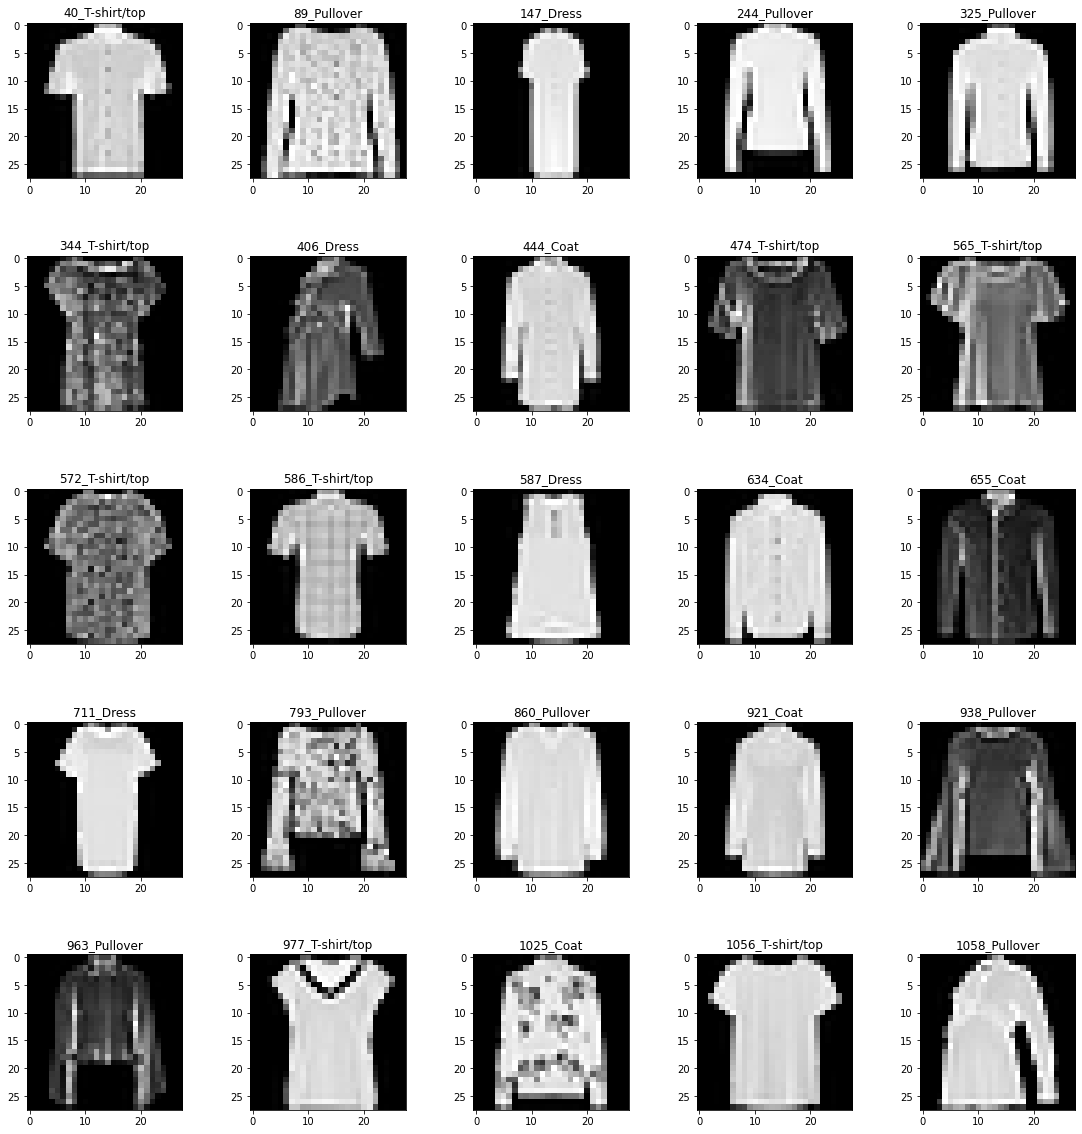

In [48]:
fig, axs = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for j in range(25):
    i=shirt_wrong_ind[j]
    axs[j].imshow(Fmnist_test[i][0].numpy().reshape((28,28)), cmap='gray')
    axs[j].set_title(str(i)+'_'+labels_f[y_pred[i].item()])

In [0]:
# Кажется, что сложный класс
# Конец решения